# CS295/395: Secure Distributed Computation
## Homework 8

## Useful Definitions for FV FHE Scheme

Reference: [Somewhat Practical Fully Homomorphic Encryption](https://eprint.iacr.org/2012/144.pdf) (2012).

In [125]:
import random
import numpy as np
from collections import defaultdict
from collections import namedtuple

q = 2**32
p = q**3

t = 2

def noise():
    return random.randint(-5, 5) % q

def keygen():
    s = random.randint(0, t-1)
    a = random.randint(1, q-1)
    e = noise()
    pk = (-(a*s+e)%q, a)
    return s,pk

def eval_keygen(sk):
    s = sk
    a = random.randint(1, p*q-1)
    e = noise()
    rlk = (-(a*s + e) + p * s**2) % (p*q)
    return (rlk, a)

def encrypt(pk, m):
    p0, p1 = pk
    u = random.randint(0, t-1)
    e1 = noise()
    e2 = noise()
    Delta = int(q / t)
    ct1 = (p0*u + e1 + Delta*m) % q
    ct2 = (p1 * u + e2) % q
    return (ct1, ct2)

def decrypt(sk, ct):
    s = sk
    c0, c1 = ct
    m = round(t * ((c0 + c1 * s) % q) / q) % t
    return m

def e_add(ct1, ct2):
    o1 = (ct1[0] + ct2[0]) % q
    o2 = (ct1[1] + ct2[1]) % q
    return (o1, o2)

def e_mul(ct1, ct2, rlk):
    # multiplication
    c0 = round((t*(ct1[0] * ct2[0]))/q) % q
    c1 = round((t*(ct1[0]*ct2[1] + ct1[1] * ct2[0])) / q) % q
    c2 = round((t*(ct1[1]*ct2[1])) / q) % q
    
    # degree reduction
    c20 = round((c2*rlk[0])/p) % q
    c21 = round((c2*rlk[1])/p) % q
    
    return ((c0 + c20) % q, (c1 + c21) % q)

## Circuit Definitions

In [76]:
from dataclasses import dataclass

@dataclass
class Gate:
    type: str
    in1: int
    in2: int
    out: int

@dataclass
class Circuit:
    inputs: any
    outputs: any
    gates: any

## Question 1 (20 points)

Implement a function `fv_eval_circuit` that evaluates a circuit given ciphertexts for its inputs.

In [77]:
def fv_eval_circuit(circuit, inputs, pk, rlk):
    wire_dict = {}

    # load all the (encrypted) inputs into wire dict
    for i in range(len(inputs)):
        wire_dict[i] = inputs[i][0]

    # evaluate each gate
    for gate in circuit.gates:
        if gate.type == 'AND':
            wire_dict[gate.out] = e_mul(wire_dict[gate.in1], wire_dict[gate.in2], rlk)
        elif gate.type == 'XOR':
            wire_dict[gate.out] = e_add(wire_dict[gate.in1], wire_dict[gate.in2])
        else:
            raise Exception('Unknown gate type')

    return [wire_dict[i] for i in circuit.outputs]

In [78]:
# TEST CASE: add x and y

# Generate keys
sk, pk = keygen()
rlk = eval_keygen(sk)

# Encrypt inputs
inputs = [[encrypt(pk, 0)], [encrypt(pk, 1)]]

# Build circuit
gates = [Gate('XOR', 0, 1, 2),
         Gate('AND', 2, 1, 3),
         Gate('AND', 3, 1, 4),
         Gate('AND', 3, 0, 5)]
input_wires = [[0], [1]]
output_wires = [4, 5]
circuit = Circuit(input_wires, output_wires, gates)

# Run the circuit
outputs = fv_eval_circuit(circuit, inputs, pk, rlk)

assert [decrypt(sk, v) for v in outputs] == [1, 0]

## Question 2 (20 points)

Implement a function that adds two *integers* using the FV SHE scheme. Your solution should take two integers and a bitwidth ($n$), and:

1. Convert the two integers into bit-strings (lists of bits) using `convert_to_bitstring`
2. Generate a keypair (public, secret, and relinearization keys)
3. Encrypt each bit of the two bit-strings
4. Construct a bitstring adder circuit using `construct_adder_circuit`
5. Construct the `inputs` list containing the encrypted values from (3)
6. Evaluate the circuit on the inputs
7. Construct an encrypted bit-string for the result from the output wire values
8. Decrypt each bit of the result from (7)
9. Convert the decrypted bit-string from (8) back into an integer and return it

In [79]:
def convert_to_bitstring(i, num_bits):
    s = f'{i:0{num_bits}b}'
    return [int(s) for s in reversed(s)]

def convert_to_int(bitstring):
    return int("".join([str(v) for v in reversed(bitstring)]), 2)

def construct_adder_circuit(num_bits):
    ins1 = list(range(0, num_bits))
    ins2 = list(range(num_bits, 2*num_bits))
    inputs = [ins1, ins2]
    current_wire = 2*num_bits
    gates = []
    outputs = []
    carry_wire = None
    
    for a, b in zip(ins1, ins2):
        if carry_wire is not None:
            ab, abc, anb, cinab, cout = range(current_wire, current_wire + 5)
            current_wire += 5
            gates += [Gate('XOR', a, b, ab),
                      Gate('XOR', ab, carry_wire, abc),
                      Gate('AND', a, b, anb),
                      Gate('AND', carry_wire, ab, cinab),
                      Gate('XOR', anb, cinab, cout)]
            outputs.append(abc)
        else:
            ab, cout = range(current_wire, current_wire + 2)
            current_wire += 2
            gates += [Gate('XOR', a, b, ab),
                      Gate('AND', a, b, cout)]            
            outputs.append(ab)
        carry_wire = cout
        
    circuit = Circuit(inputs, outputs, gates)
    return circuit

Implement your function below:

In [80]:
def add_ints(x, y, bitwidth):
    # 1. Convert the two integers into bit-strings (lists of bits) using `convert_to_bitstring`
    x_bits = convert_to_bitstring(x, bitwidth)
    y_bits = convert_to_bitstring(y, bitwidth)
    # 2. Generate a keypair (public, secret, and relinearization keys)
    sk, pk = keygen()
    rlk = eval_keygen(sk)
    # 3. Encrypt each bit of the two bit-strings
    x_enc = [encrypt(pk, v) for v in x_bits]
    y_enc = [encrypt(pk, v) for v in y_bits]
    # 4. Construct a bitstring adder circuit using `construct_adder_circuit`
    circuit = construct_adder_circuit(bitwidth)
    # 5. Construct the `inputs` list containing the encrypted values from (3)
    inputs = list(map(lambda thing: [thing],[*x_enc, *y_enc]))
    # 6. Evaluate the circuit on the inputs
    outputs = fv_eval_circuit(circuit, inputs, pk, rlk)
    # 7. Construct an encrypted bit-string for the result from the output wire values
    result = [decrypt(sk, v) for v in outputs]
    # 8. Decrypt each bit of the result from (7)
    result = convert_to_int(result)
    # 9. Convert the decrypted bit-string from (8) back into an integer and return it
    return result
    
# Examples
print('Adding 7 and 2, 8-bit:', add_ints(7, 2, 8))
print('Adding 7 and 2, 16-bit:', add_ints(7, 2, 16))
print('Adding 7 and 2, 32-bit:', add_ints(7, 2, 32))
print('Adding 7 and 2, 64-bit:', add_ints(7, 2, 64))

Adding 7 and 2, 8-bit: 9
Adding 7 and 2, 16-bit: 9
Adding 7 and 2, 32-bit: 9
Adding 7 and 2, 64-bit: 5764607523034234889


In [81]:
# TEST CASE
assert add_ints(5, 2, 8) == 7
assert add_ints(5, 2, 16) == 7
assert add_ints(5, 2, 64) == 7  ## Sometimes, too much noise for this one!

## Question 3 (20 points)

In 1-2 sentences each, answer the following:

- How many gates are required for the 8-bit addition? How many are required for the 16-bit addition?
- Try performing 64-bit or 128-bit addition (or even higher). At what bitwidth do you start to see wrong answers?
- Why do you sometimes get the wrong answer for larger bitwidths?
- What parameter would you change to make these errors go away? How would you change it, and why?
- Is the addition circuit "wide" or "deep"? In other words, how large is the longest path (in terms of gates) from an input to the output, relative to the total number of gates?
- Would you expect noise to be worse in the case of a "wide" circuit, or a "deep" circuit? Why?

### **How many gates are required for 8 bit addition? 16 bit addition?**

In [82]:
for n in [8, 16, 32, 64, 128]:
    print(f"{n}-bit adder circuit length:", len(construct_adder_circuit(n).gates))

8-bit adder circuit length: 37
16-bit adder circuit length: 77
32-bit adder circuit length: 157
64-bit adder circuit length: 317
128-bit adder circuit length: 637



### **Try performing 64-bit or 128-bit addition (or even higher). At what bitwidth do you start to see wrong answers?**


In [127]:
trials = 500
for exp in range(3, 10):
    bitwidth = 2**exp

    successes = 0
    for _ in range(trials):
        successes += 1 if add_ints(10, 10, bitwidth) == 20 else 0

    print(f"{bitwidth}-bit adder circuit success rate: {100 * successes/trials} %")

8-bit adder circuit success rate: 100.0 %
16-bit adder circuit success rate: 100.0 %
32-bit adder circuit success rate: 88.8 %
64-bit adder circuit success rate: 67.8 %
128-bit adder circuit success rate: 57.6 %
256-bit adder circuit success rate: 49.0 %
512-bit adder circuit success rate: 46.0 %


By the 32 bit mark we are already at non-perfect 83% accuracy, and by 256 bits we are only accurate ~ half the time!

### **Why do you sometimes get the wrong answer for larger bitwidths?**

There are a growing number of gates as we increase the bit width and the more gates in series that the encrypted values must travel through, the larger the error has the chance to become. 

### **What parameter would you change to make these errors go away? How would you change it, and why?**

I would make q larger which allows the protocol to tolerate more noise.

### **Is the addition circuit "wide" or "deep"? In other words, how large is the longest path (in terms of gates) from an input to the output, relative to the total number of gates?**

100%|██████████| 7/7 [00:00<00:00, 27.56it/s]


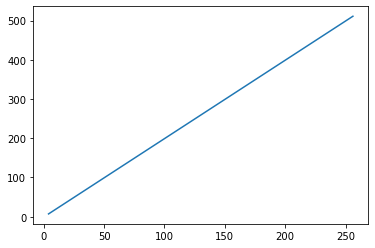

In [173]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

xs = []
ys = []

for n in tqdm(range(2, 9)):
    bw = 2**n
    c = construct_adder_circuit(bw)

    num_wires = c.outputs[-1]
    G = nx.DiGraph()
    G.add_nodes_from(range(num_wires))

    for gate in tqdm(c.gates, leave=False):
        G.add_edge(gate.in1, gate.out)
        G.add_edge(gate.in2, gate.out)

    xs.append(bw)
    ys.append(nx.dag_longest_path_length(G))

plt.plot(xs, ys)
plt.show()


The circuit depth increases linearly with bitwidth and looks to be ~2x bit width. For 256 bit width this is 511 circuits deep which is a lot making this a deep circuit. It is worth noting that the depth scales with O(n) which is not terrible. 

### **Would you expect noise to be worse in the case of a "wide" circuit, or a "deep" circuit? Why?**

The noise compounds with depth not width. This is because noise from parential gates accumulates in the children, but noise from sibling gates does not affect children.